In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

In [2]:
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv') 
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [3]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [5]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))

In [6]:
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [7]:
data['text_clean'].head()

0    just got back from seeing garydelaney in bursl...
1    oh dear an evening of absolute hilarity i dont...
2     been waiting all week for this game cheer friday
3    gardiner_love  thank you so much gloria youre ...
4    i feel so blessed to work with the family that...
Name: text_clean, dtype: object

<Axes: xlabel='label'>

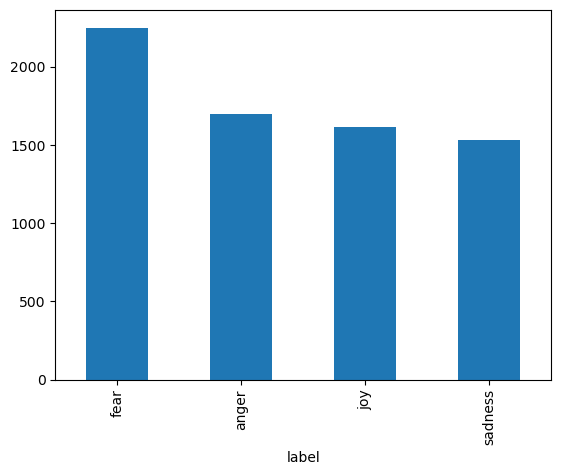

In [8]:
data['label'].value_counts().plot(kind='bar')

In [9]:
g = data.groupby('label')

In [10]:
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/var/folders/_l/x7sst6vd3cxcyz5906k1b_s40000gn/T/ipykernel_16924/2703046170.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

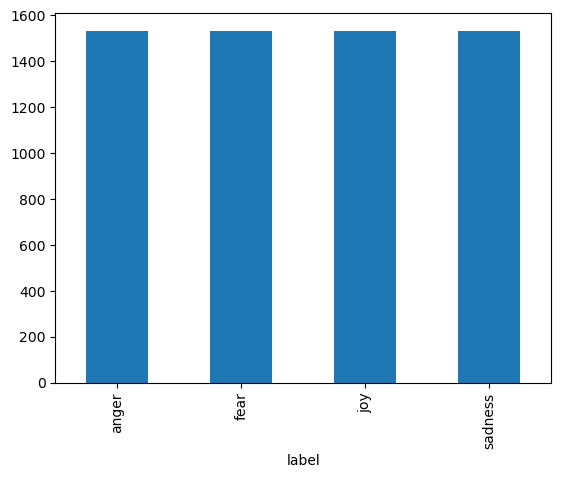

In [11]:
data['label'].value_counts().plot(kind='bar')

In [12]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [13]:
data.head()

text  label  \
label                                                               
anger 0  @voguemagazine, did you not learn from @FreePe...  anger   
      1  Ive always wondered how long Angelina put up w...  anger   
      2  @hollyrobinson__ Part 2-was buzzing for a chee...  anger   
      3                   So fucking mad my blood boiling.  anger   
      4  @RLH2606 if u know who died.. I would also bur...  anger   

                                                text_clean  label_int  
label                                                                  
anger 0  voguemagazine did you not learn from freepeopl...          0  
      1  ive always wondered how long angelina put up w...          0  
      2  hollyrobinson__ part 2was buzzing for a cheeky...          0  
      3                    so fucking mad my blood boiling          0  
      4  rlh2606 if u know who died i would also burst ...          0

In [14]:
NUM_LABELS = 4

In [15]:
train_split, test_split = train_test_split(data, train_size=0.8)
train_split, val_split = train_test_split(train_split, train_size=0.9)

In [16]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [17]:
train_df = pd.DataFrame({
    "label" : train_split.label_int.values,
    "text" : train_split.text_clean.values
})

In [18]:
test_df = pd.DataFrame({
    "label" : test_split.label_int.values,
    "text" : test_split.text_clean.values
})

In [19]:
train_df.head()

,label,text
0,0,yeah no i don mind tweetin that twice blm like...
1,1,whats up cowboys horrible
2,1,tweeting from the sporadic wifi on the tube
3,0,luxbet did you even give out any pizzas serio...
4,2,steenfox im feeling the exact same way also i ...


In [20]:
test_df.head()

,label,text
0,0,noris_prosk8r2 maybe dont provoke him in the f...
1,3,the voice is all about miley and alicia this y...
2,0,my mom cut my phone off and im so furious
3,2,god facebooks design has started to remind me ...
4,0,absolutely fuming ive just scratched all my car


In [21]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [22]:
train_df

Dataset({
    features: ['label', 'text'],
    num_rows: 4414
})

In [23]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [24]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

## Create Embeddings

In [26]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [27]:
def create_tokens(examples):
    return tokenizer(examples['text'], padding="max_length", max_length=128, truncation=True)

In [28]:
tokenized_dataset = dataset_dict.map(function=create_tokens, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [30]:
tokenized_dataset['train']['text'][0]

'yeah no i don mind tweetin that twice blm likethat'

In [31]:
tokenized_dataset['train']['input_ids'][0]

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 11752,
 116,
 17,
 150,
 220,
 823,
 19291,
 153,
 29,
 2202,
 17,
 11862,
 98,
 115,
 4331,
 4,
 3]

In [32]:
tokenizer.decode(5)

'<pad>'

In [33]:
tokenized_dataset['train']['token_type_ids'][0]

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2]

In [34]:
tokenized_dataset['train']['attention_mask'][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [46]:
small_train_dataset = tokenized_dataset['train'].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_dataset['test'].shuffle(seed=42).select(range(100))

In [48]:
small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

In [50]:
small_eval_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

## Fine Tuning

In [53]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                      num_labels=NUM_LABELS,
                                                      id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
metric = evaluate.load('accuracy')

In [55]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [56]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [58]:
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [59]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.464463,0.200000
2,No log,1.362710,0.300000
3,No log,1.382669,0.310000


TrainOutput(global_step=39, training_loss=1.4305372971754808, metrics={'train_runtime': 44.6621, 'train_samples_per_second': 6.717, 'train_steps_per_second': 0.873, 'total_flos': 21366375321600.0, 'train_loss': 1.4305372971754808, 'epoch': 3.0})

In [71]:
trainer.evaluate()

{'eval_loss': 1.38266921043396,
 'eval_accuracy': 0.31,
 'eval_runtime': 3.0999,
 'eval_samples_per_second': 32.259,
 'eval_steps_per_second': 4.194,
 'epoch': 3.0}

In [72]:
model.save_pretrained("fine_tuned_model")

In [73]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [74]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use mps:0


In [79]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

/var/folders/_l/x7sst6vd3cxcyz5906k1b_s40000gn/T/ipykernel_16924/3116462782.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/var/folders/_l/x7sst6vd3cxcyz5906k1b_s40000gn/T/ipykernel_16924/3116462782.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)


oh goodness im loving this rainy day its a head down creative cap on  get lost in your thoughts kind of day art create biz
[{'label': 'anger', 'score': 0.3265262842178345}, {'label': 'fear', 'score': 0.23688916862010956}, {'label': 'joy', 'score': 0.2282562553882599}, {'label': 'sadness', 'score': 0.20832830667495728}]
